In [1]:
from graph import Node
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, dr="LR"):
    dot = Digraph(format="svg", graph_attr={"rankdir": dr})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.2f | grad %.3f  }" % (n.label, n.data, n._grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [2]:
# Base case: A toy example
a = Node(2.0, label='a')
b = Node(-3.0, label='b')
c = Node(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Node(-2.0, label='f')
L = d * f; L.label = 'L'
L.backward()

order of backprop: 
Node(data=-8.0, label=L, grad=1)
Node(data=-2.0, label=f, grad=0.0)
Node(data=4.0, label=d, grad=0.0)
Node(data=10.0, label=c, grad=0.0)
Node(data=-6.0, label=e, grad=0.0)
Node(data=-3.0, label=b, grad=0.0)
Node(data=2.0, label=a, grad=0.0)


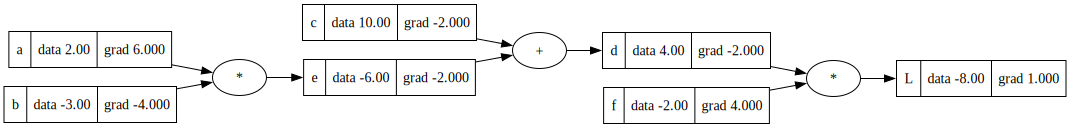

In [3]:
draw_dot(L)

In [4]:
# inputs x1,x2
x1 = Node(2.0, label='x1')
x2 = Node(0.0, label='x2')
# weights w1,w2
w1 = Node(-3.0, label='w1')
w2 = Node(1.0, label='w2')
# bias of the neuron
b = Node(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

order of backprop: 
Node(data=0.7071067811865476, label=o, grad=1)
Node(data=0.8813735870195432, label=n, grad=0.0)
Node(data=6.881373587019543, label=b, grad=0.0)
Node(data=-6.0, label=x1*w1 + x2*w2, grad=0.0)
Node(data=-6.0, label=x1*w1, grad=0.0)
Node(data=-3.0, label=w1, grad=0.0)
Node(data=2.0, label=x1, grad=0.0)
Node(data=0.0, label=x2*w2, grad=0.0)
Node(data=1.0, label=w2, grad=0.0)
Node(data=0.0, label=x2, grad=0.0)


In [5]:
print(w1._grad)
print(w2._grad)
print(b._grad)

0.9999999999999998
0.0
0.4999999999999999


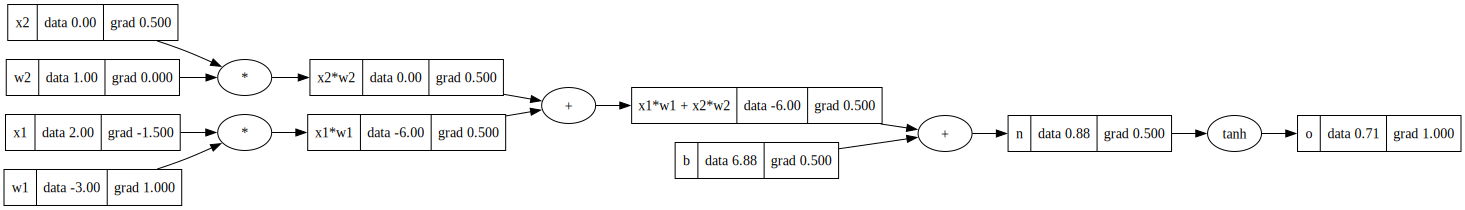

In [6]:
draw_dot(o)

In [7]:
# Implementation in Pytorch
import torch

x1 = torch.Tensor([2]).double(); x1.requires_grad = True
x2 = torch.Tensor([0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3]).double(); w1.requires_grad = True
w2 = torch.Tensor([1]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

x1w1 = x1*w1
x2w2 = x2*w2
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
o = n.tanh()
o.backward()

# Verify that this matches the above micrograd implementation
print(w1._grad.item())
print(w2._grad.item())
print(b._grad.item())

1.0000002567688737
0.0
0.5000001283844369


order of backprop: 
Node(data=6.0, label=b, grad=1)
Node(data=3.0, label=a, grad=0.0)


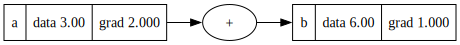

In [8]:
a = Node(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

order of backprop: 
Node(data=-6.0, label=f, grad=1)
Node(data=1.0, label=e, grad=0.0)
Node(data=-6.0, label=d, grad=0.0)
Node(data=3.0, label=b, grad=0.0)
Node(data=-2.0, label=a, grad=0.0)


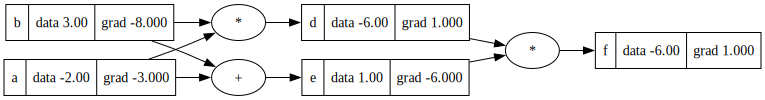

In [9]:
a = Node(-2.0, label='a')
b = Node(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'
f.backward()
draw_dot(f)